   # Forest Cover Type Classification
   
   ### Objective: Build a deep learning model to predict the forest cover type from different cartographic variables. 
1. A good model.
2. Model performance over epochs (accuracy, loss plots)
3. Some classification metrics (heatmap of confusion-matrix, classification-report etc).
4. Conclusions, thoughts and ways to improve classification accuracy.

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
!pip install sweetviz
import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2025-09-19 06:04:16.030966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758261856.256338      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758261856.319829      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 104.7 MB/s eta 0:00:0000:01:01


In [2]:
# Disable those annoying warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

## Define Some Helper Functions

Prepare data that can be readily consumed by ML/DL algorithms.
- separate features from class variables
- split into training and testing dataset
- scale numerical data
    
param: a dataframe of input data
output: X_train_normalized, X_test_normalized, y_train, y_test

In [3]:
def prep_data(raw_df):
    raw_data = raw_df.values
    X, y = raw_data[:, :-1], raw_data[:, -1]

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    # normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

Build the model architecture (and compile it).

input: number of features

output: Keras model object.

In [4]:
def build_model(num_features):
    classifier = keras.Sequential()
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(32, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(8, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

Function to compute a Confusion Matrix and plot a heatmap based on the matrix.

input: class names, y-predicted, y-test (ground-truth)

output: a PNG file of the heatmap.

In [10]:
def plot_heatmap(class_names, y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'/kaggle/working//confusion_matrix.png')

Shows how the model performs (in terms of accuracy and loss) over several epochs.

In [6]:
def plot_history(history, param):
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

### The main function below drives the entire code. It prepares the dataset, builds a model with appropriate parameters, evaluates the model and predicts on the test data. Finally, plots some performance metrics.

In [11]:
def main():
    infile = '/kaggle/input/cover-data/cover_data.csv'
    raw_df = pd.read_csv(infile)

    # EDA
    my_report = sv.analyze(raw_df)
    my_report.show_html()

    cols = raw_df.columns.tolist()
    features, label = cols[:-1], cols[-1]
    X_train, X_test, y_train, y_test = prep_data(raw_df)

    # Build a DL model
    num_features = len(features)
    model = build_model(num_features)

    print("Summary report of Keras classifier:")
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Summary report of Keras classifier:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,864 (22.91 KB)

 Trainable params: 5,864 (22.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5944 - loss: 1.0574 - val_accuracy: 0.7435 - val_loss: 0.6081
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.5911 - val_accuracy: 0.7598 - val_loss: 0.5587
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.5467 - val_accuracy: 0.7746 - val_loss: 0.5254
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7770 - loss: 0.5186 - val_accuracy: 0.7826 - val_loss: 0.5056
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7854 - loss: 0.4973 - val_accuracy: 0.7900 - val_loss: 0.4893
Epoch 6/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7919 - loss: 0.4849 - val_accuracy: 0.7954 - val_loss: 0.4772
Epoch 7/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7983 - loss: 0.4713 - val_accuracy: 0.8017 - val_loss: 0.4654
Epoch 8/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8030 - loss: 0.4618 - val_accu

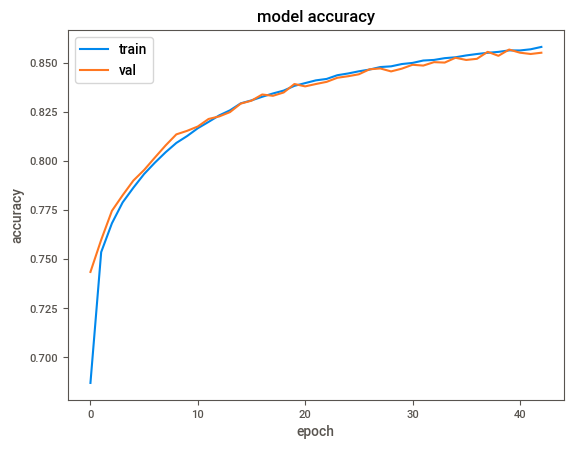

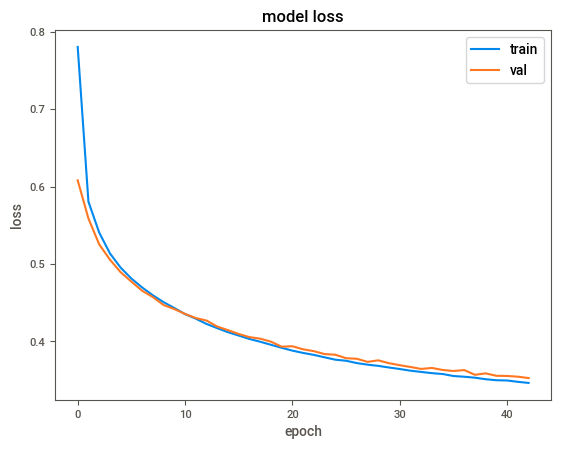

Test loss: 0.35385823249816895
Test accuracy: 0.8542378544807434
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 3s 826us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.87      0.82      0.85     42368
   Lodgepole Pine       0.85      0.91      0.88     56661
   Ponderosa Pine       0.79      0.90      0.84      7151
Cottonwood/Willow       0.85      0.61      0.71       549
            Aspen       0.72      0.51      0.59      1899
      Douglas-fir       0.79      0.54      0.64      3473
        Krummholz       0.88      0.85      0.87      4102

         accuracy                           0.85    116203
        macro avg       0.82      0.73      0.77    116203
     weighted avg       0.85      0.85      0.85    116203



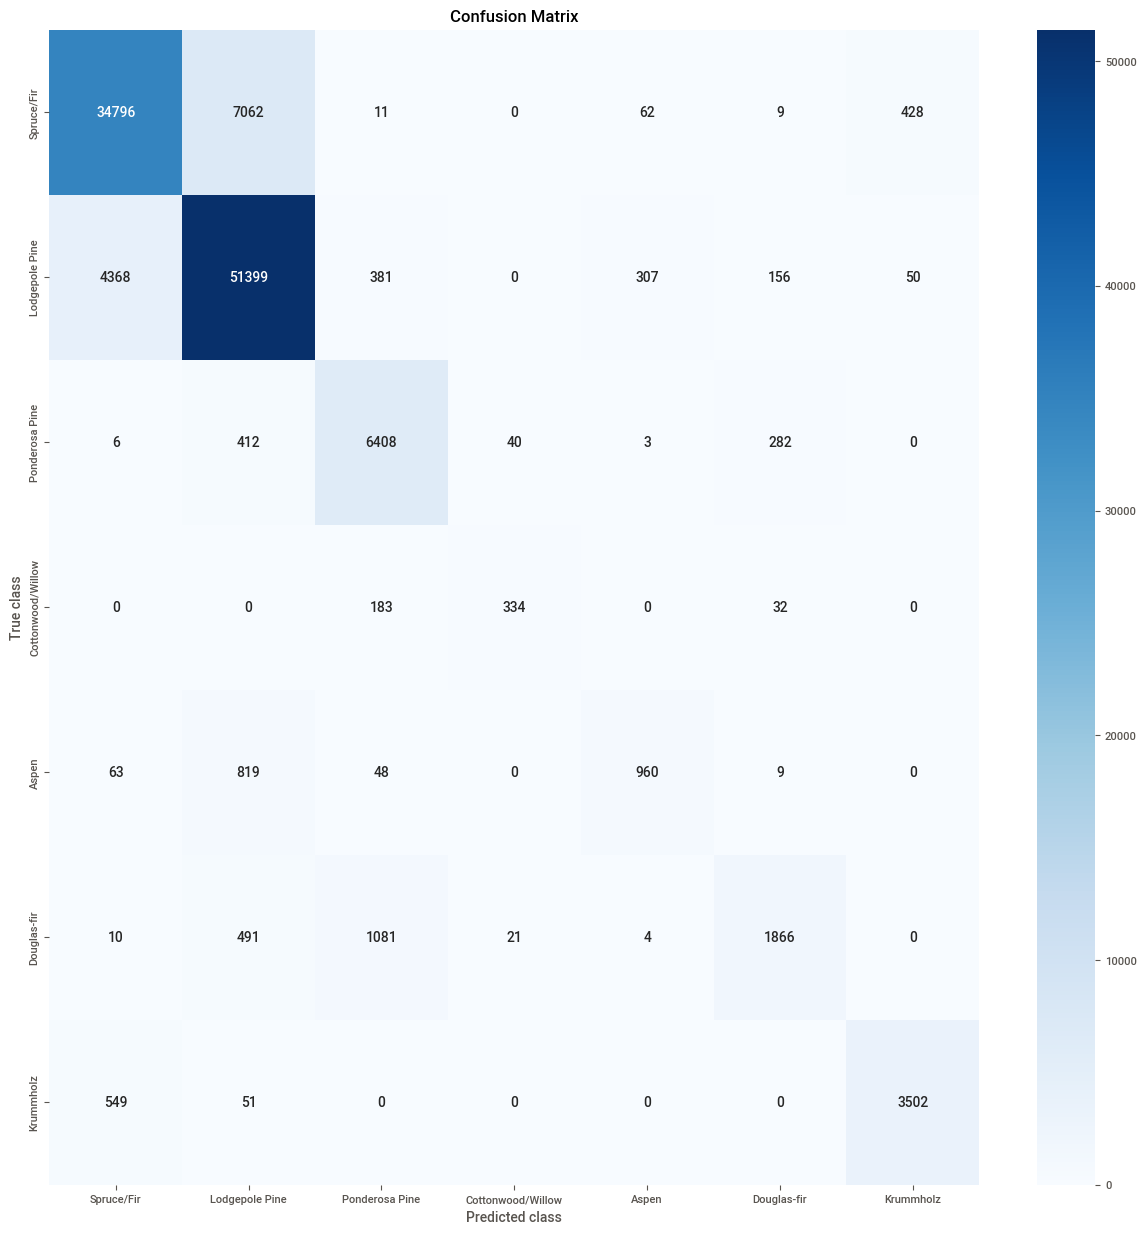

In [12]:
if __name__ == '__main__':
    main()

### Conclusions: 
The diagonal values in the heatmap represent the correctly classified instances, while the off-diagonal values indicate misclassifications. Notably, Lodgepole Pine, Cottonwood Willow, Aspen, and Douglas-Fir show a high rate of misclassification. To further analyze potential causes, the following steps can be considered:

1. Examine the class distribution for each cover type. Any imbalance in the dataset can negatively impact classification.

2. Assess how observations are spread across different wilderness areas.

3. Investigate similarities between cover types (through correlation analysis, scatter plots, etc.). Such overlap may confuse the model. A possible remedy is to eliminate collinear features, retaining only one representative variable.

4. Clean the dataset by removing noise, inconsistencies, or errors—ideally with the help of domain experts.

5. Evaluate the model with metrics beyond simple accuracy. Accuracy is unreliable under class imbalance; metrics such as Precision, Recall, or F1-score provide better insight.

6. Apply resampling techniques (oversampling, undersampling, or stratified sampling). Downsampling, for example, can be performed using thresholding.

The key takeaway is that in deep learning, the gradients of the majority class tend to dominate, strongly influencing weight updates. More advanced methods exist to mitigate this issue.